# Восканян Юрий, КИ22-17/1б
### Практическая работа 7. Кластеризация 

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, \
    homogeneity_completeness_v_measure
from sklearn.decomposition import PCA

In [255]:
df = pd.read_csv('train.csv', index_col='PassengerId')
index_column = df.index

y_train = df['Survived']

df = df.drop(columns=['Survived'])
df.describe()


,Pclass,Age,SibSp,Parch,Fare
count,534.000000,432.000000,534.000000,534.00000,534.000000
mean,2.327715,29.612662,0.548689,0.38015,32.780453
std,0.839514,14.740699,1.206793,0.81936,52.203248
min,1.000000,0.420000,0.000000,0.00000,0.000000
25%,2.000000,20.000000,0.000000,0.00000,7.895800
50%,3.000000,28.000000,0.000000,0.00000,13.000000
75%,3.000000,38.250000,1.000000,0.00000,31.275000
max,3.000000,80.000000,8.000000,6.00000,512.329200


## 2.Предварительная обработка данных

In [256]:
# Проверка типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534 entries, 486 to 461
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    534 non-null    int64  
 1   Name      534 non-null    object 
 2   Sex       534 non-null    object 
 3   Age       432 non-null    float64
 4   SibSp     534 non-null    int64  
 5   Parch     534 non-null    int64  
 6   Ticket    534 non-null    object 
 7   Fare      534 non-null    float64
 8   Cabin     120 non-null    object 
 9   Embarked  534 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 45.9+ KB


In [257]:
df.describe()

,Pclass,Age,SibSp,Parch,Fare
count,534.000000,432.000000,534.000000,534.00000,534.000000
mean,2.327715,29.612662,0.548689,0.38015,32.780453
std,0.839514,14.740699,1.206793,0.81936,52.203248
min,1.000000,0.420000,0.000000,0.00000,0.000000
25%,2.000000,20.000000,0.000000,0.00000,7.895800
50%,3.000000,28.000000,0.000000,0.00000,13.000000
75%,3.000000,38.250000,1.000000,0.00000,31.275000
max,3.000000,80.000000,8.000000,6.00000,512.329200


<Axes: >

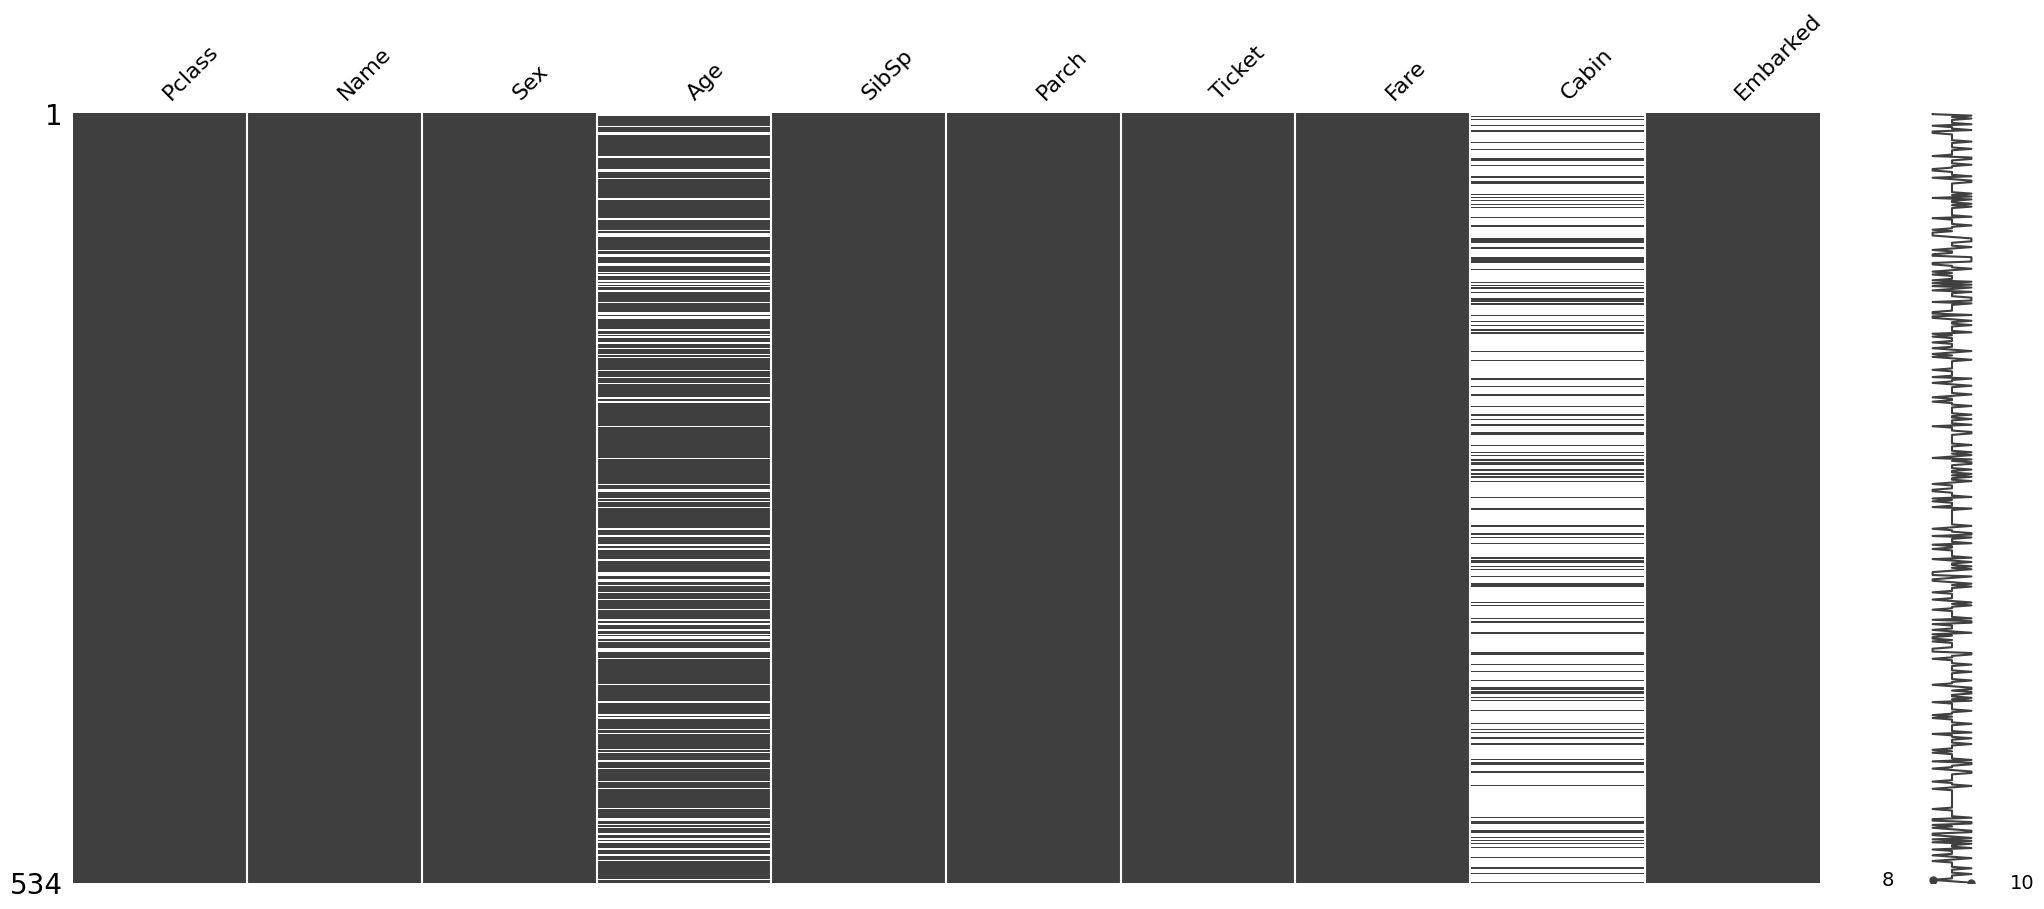

In [258]:
# Проверка пропусков
missingno.matrix(df)

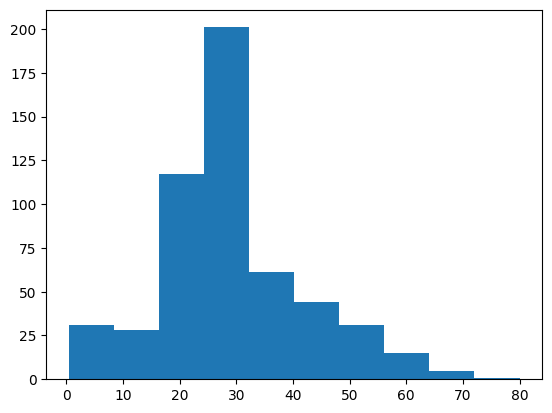

In [259]:
imp = KNNImputer(missing_values=np.nan)
# df['Age'] = imp.fit_transform(df.values.reshape(-1, 1))
df['Age'] = df['Age'].fillna(df['Age'].mean())
plt.hist(df['Age'])
plt.show()

In [260]:
# Удалим столбец Cabin
del df['Cabin']

In [261]:
# Удалим не нужные столбцы из data frame
df.drop(columns=['Name', 'Ticket', 'Fare'], inplace=True)

<Axes: >

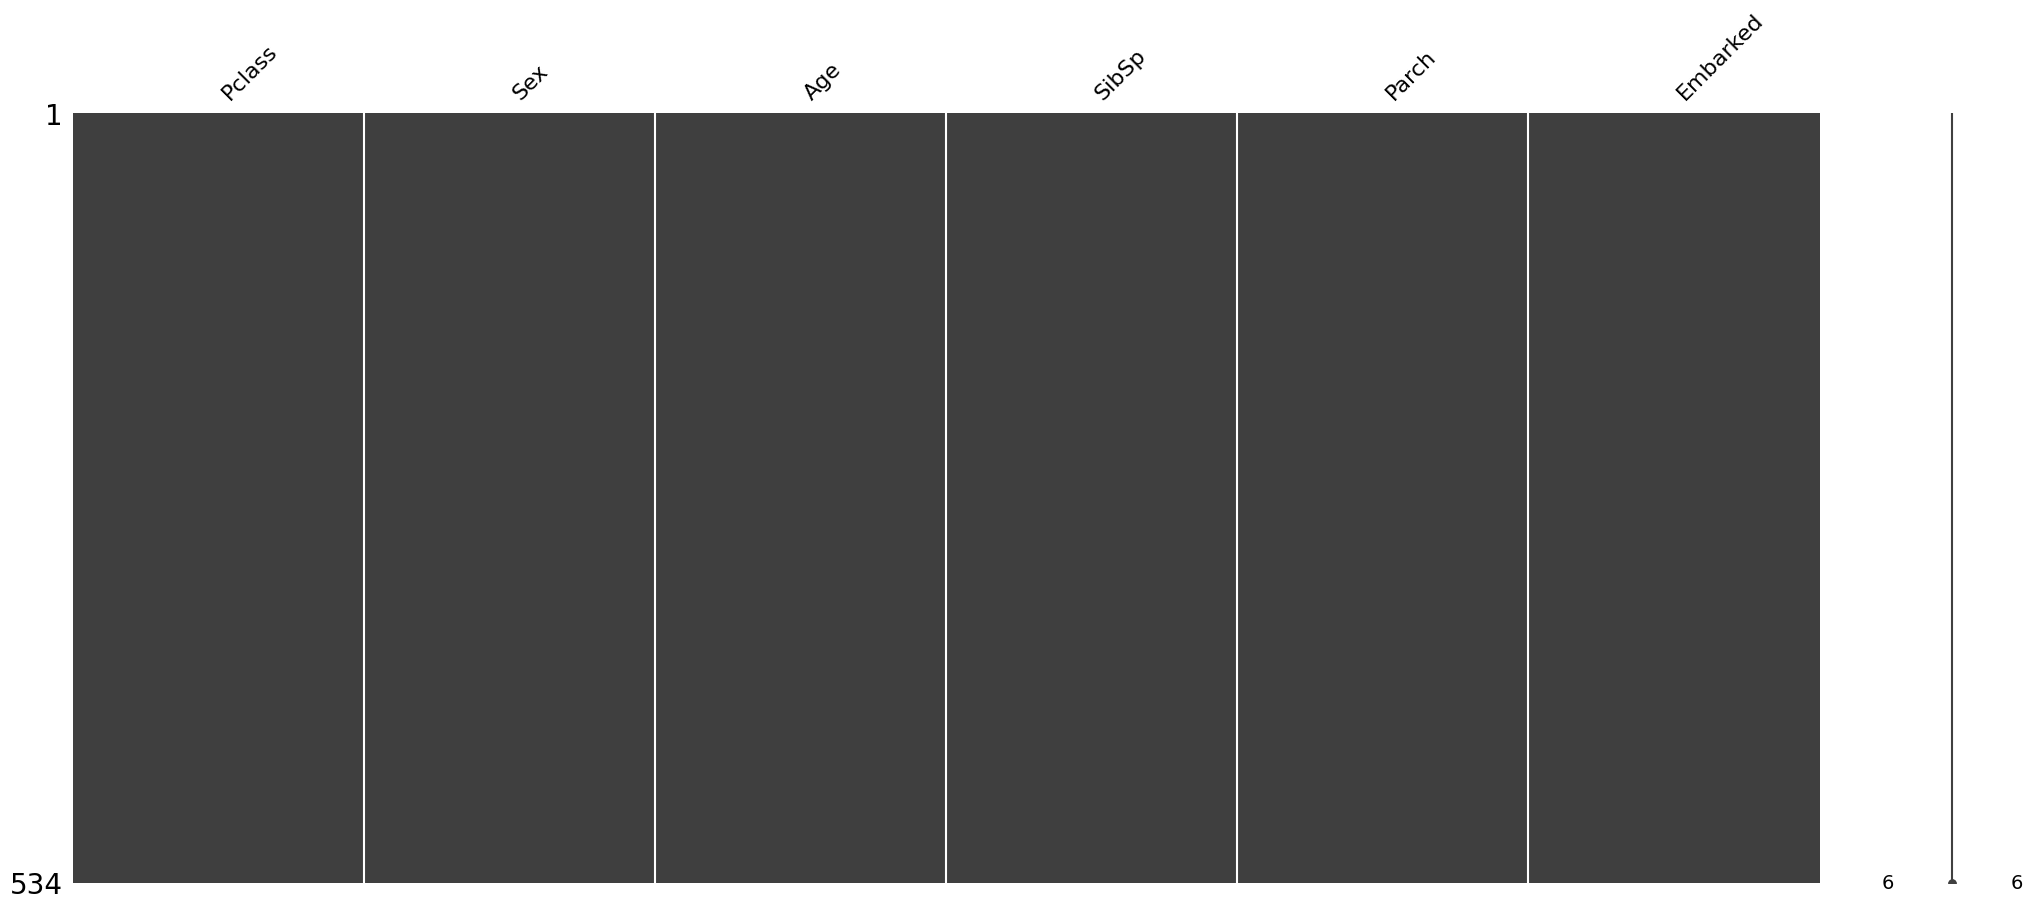

In [262]:
missingno.matrix(df)

In [263]:
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
standard_scaler = StandardScaler()

In [264]:
# Удаление выбросов
def sigmaclip(d, s, low=4, high=4):
    mean = d[s].mean()
    std = d[s].std()
    return d[(d[s].isna()) | ((d[s] >= mean - std * low) & (d[s] <= mean + std * high))]


# df = sigmaclip(df, 'Fare')
# Применение OneHotEncoder к категориальным переменным
categorical_variables = ['Sex', 'Embarked']
transformed = one_hot_encoder.fit_transform(df[categorical_variables])
encoded = pd.DataFrame(transformed, index=df.index)
encoded.columns = one_hot_encoder.get_feature_names_out()
df = df.join(encoded)
df.drop(columns=['Sex', 'Embarked'], inplace=True)



In [265]:
# применение standard_scaler к числовым переменным
numeric_variables = ['Pclass', 'Age', 'SibSp', 'Parch']
df[numeric_variables] = standard_scaler.fit_transform(df[numeric_variables])

df.head()

,Pclass,Age,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,
486,0.801553,5.365425e-16,2.033165,0.757215,0.0,0.0,1.0
426,0.801553,5.365425e-16,-0.455094,-0.464395,1.0,0.0,1.0
780,-1.583011,1.010900e+00,-0.455094,0.757215,0.0,0.0,1.0
248,-0.390729,-4.238213e-01,-0.455094,1.978825,0.0,0.0,1.0
184,-0.390729,-2.160589e+00,1.203746,0.757215,1.0,0.0,1.0


### Построение моделей кластеризации данных

In [266]:
k_means = KMeans(n_clusters=2)
labels = k_means.fit_predict(df)
score = adjusted_rand_score(y_train, labels)
print(f'Adjusted Rand index score: {score}')

Adjusted Rand index score: 0.1012608663192556


C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [267]:
score = adjusted_mutual_info_score(y_train, labels)
print(f'adjusted_mutual_info_score: {score}')

adjusted_mutual_info_score: 0.0585886218534684


In [268]:
score = homogeneity_completeness_v_measure(y_train, labels)
print(f'homogeneity_completeness_v_measure: {score}')

homogeneity_completeness_v_measure: (0.05915309151516688, 0.06072188457994112, 0.05992722272045966)


In [269]:
score = silhouette_score(df, labels)
print(f'silhouette_score: {score}')

silhouette_score: 0.2788970598765163


In [270]:
agglomerative_clustering = AgglomerativeClustering(n_clusters=2)
labels = agglomerative_clustering.fit_predict(df)

In [271]:
score = adjusted_rand_score(y_train, labels)
print(f'adjusted_rand_score: {score}')

adjusted_rand_score: 0.023683187925128277


In [272]:
score = adjusted_mutual_info_score(y_train, labels)
print(f'adjusted_mutual_info_score: {score}')

adjusted_mutual_info_score: 0.006369162296375288


In [273]:
score = homogeneity_completeness_v_measure(y_train, labels)
print(f'homogeneity_completeness_v_measure: {score}')

homogeneity_completeness_v_measure: (0.006483055388099624, 0.010877767936188078, 0.00812417368829999)


In [274]:
score = silhouette_score(df, labels)
print(f'silhouette_score: {score}')

silhouette_score: 0.4200770730941708


## Подбор оптимального количество кластеров, используя "правило локтя"

### Подбор для алгоритма KMeans

C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarn

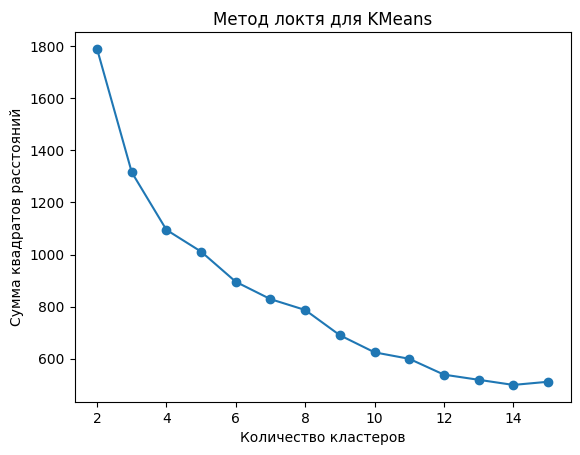

In [275]:
sum_squared_errors = []
adj_rand_score = []
adj_mutual_info_score = []
hcm_score = []
sil_score = []

for clusters_count in range(2, 16):
    kmeans = KMeans(n_clusters=clusters_count)
    kmeans.fit(df)
    sum_squared_errors.append(kmeans.inertia_)
    k_means_pred = kmeans.predict(df)
    
    adj_rand_score.append(adjusted_rand_score(y_train, k_means_pred))
    adj_mutual_info_score.append(adjusted_mutual_info_score(y_train, k_means_pred))
    hcm_score.append(homogeneity_completeness_v_measure(y_train, k_means_pred))
    sil_score.append(silhouette_score(df, k_means_pred))

plt.plot(range(2, 16), sum_squared_errors, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Сумма квадратов расстояний")
plt.title("Метод локтя для KMeans")
plt.show()



In [276]:
# k_means_optimal_clusters = range(2, 16)[np.argmax(adj_rand_score)]
k_means_optimal_clusters = 5
print(f'Оптимальное количество кластеров для KMeans: {k_means_optimal_clusters}')
print(f'adj_rand_score: {max(adj_rand_score)}')
print(f'adj_mutual_info_score: {max(adj_mutual_info_score)}')
print(f'hcm_score: {max(hcm_score)}')
print(f'sil_score: {max(sil_score)}')

Оптимальное количество кластеров для KMeans: 4
adj_rand_score: 0.1095120951711155
adj_mutual_info_score: 0.11650021966028572
hcm_score: (0.27885199933487076, 0.08016223528292811, 0.12452653641209471)
sil_score: 0.42854368797755155


### Подбор для алгоритма AgglomerativeClustering

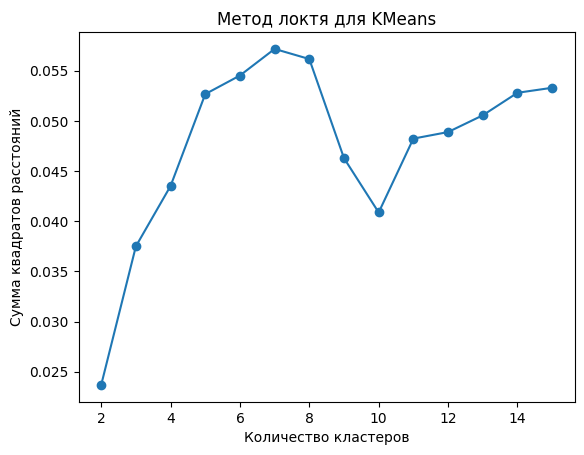

In [277]:
adj_rand_score = []
adj_mutual_info_score = []
hcm_score = []
sil_score = []

for clusters_count in range(2, 16):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=clusters_count)
    agglomerative_clustering.fit(df)
    agglomerative_clustering_pred = agglomerative_clustering.labels_
    
    adj_rand_score.append(adjusted_rand_score(y_train, agglomerative_clustering_pred))
    adj_mutual_info_score.append(adjusted_mutual_info_score(y_train, agglomerative_clustering_pred))
    hcm_score.append(homogeneity_completeness_v_measure(y_train, agglomerative_clustering_pred))
    sil_score.append(silhouette_score(df, agglomerative_clustering_pred))

plt.plot(range(2, 16), adj_rand_score, marker='o')
plt.xlabel("Количество кластеров")
plt.ylabel("Сумма квадратов расстояний")
plt.title("Метод локтя для KMeans")
plt.show()



In [278]:
# agg_optimal_clusters = range(2, 16)[np.argmax(adj_rand_score)]
agg_optimal_clusters = 8
print(f'Оптимальное количество кластеров для KMeans: {agg_optimal_clusters}')
print(f'adj_rand_score: {max(adj_rand_score)}')
print(f'adj_mutual_info_score: {max(adj_mutual_info_score)}')
print(f'hcm_score: {max(hcm_score)}')
print(f'sil_score: {max(sil_score)}')

Оптимальное количество кластеров для KMeans: 7
adj_rand_score: 0.05716459686607128
adj_mutual_info_score: 0.07515880915679209
hcm_score: (0.19336264192057212, 0.053097702383688494, 0.08331654361520567)
sil_score: 0.4200770730941708


## Визуализация для KMeans

C:\Users\amr\.conda\envs\data_science\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


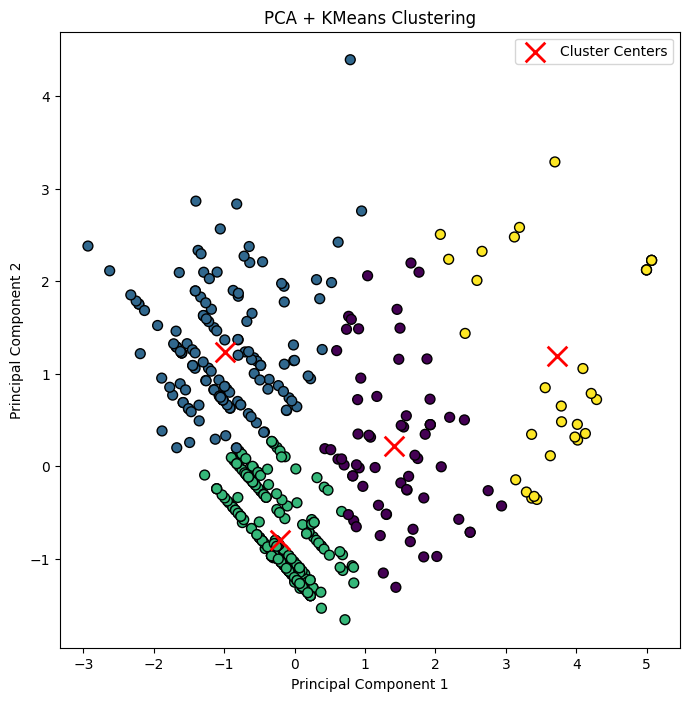

In [279]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

k_means = KMeans(n_clusters=k_means_optimal_clusters)
k_means.fit(X_pca)
labels = k_means.labels_

plt.figure(figsize=(8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

centers = k_means.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=200, linewidths=2, label='Cluster Centers')

plt.title('PCA + KMeans Clustering')
plt.legend()
plt.show()

## Визуализация для AgglomerativeClustering 

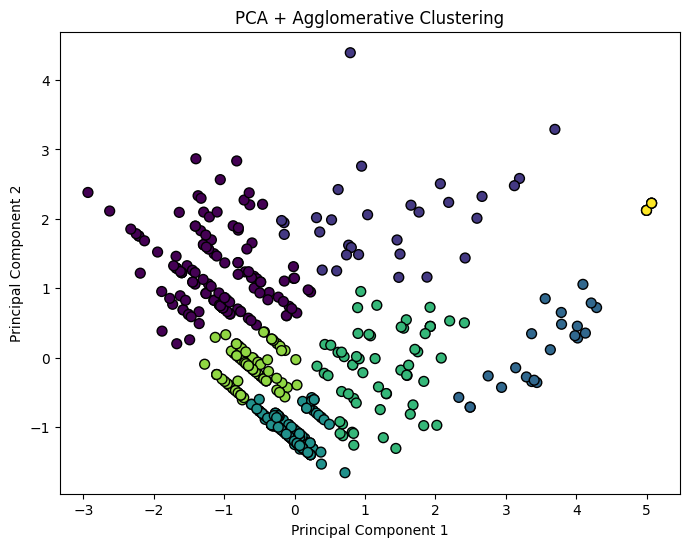

In [280]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df)

agg = AgglomerativeClustering(n_clusters=agg_optimal_clusters)
labels = agg.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('PCA + Agglomerative Clustering')
plt.show()

In [281]:
y_pred_test = agg.fit_predict(df)

result = pd.DataFrame()
result['PassengerId'] = index_column
result['Survived'] = y_pred_test
result.to_csv('result.csv', index=False)